In [0]:
!pip install kagglehub[pandas-datasets]>=0.3.8

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import kagglehub

# Descargar el dataset desde Kaggle
heart_path = kagglehub.dataset_download("kamilpytlak/personal-key-indicators-of-heart-disease")

print("Path to dataset files:", heart_path)



Path to dataset files: /home/spark-f86b6987-67a6-4f59-97e5-8f/.cache/kagglehub/datasets/kamilpytlak/personal-key-indicators-of-heart-disease/versions/6


In [0]:
# creamos el catalago para los datos bronce

catalog_name = "heart_disease"
bronze_schema = "bronze"
silver_schema = "silver"
gold_schema = "gold"

spark.sql(f"CREATE CATALOG IF NOT EXISTS {catalog_name}")
spark.sql(f"USE CATALOG {catalog_name}")


spark.sql(f"CREATE SCHEMA IF NOT EXISTS {bronze_schema}")
spark.sql(f"USE SCHEMA {bronze_schema}")

spark.sql(f"CREATE SCHEMA IF NOT EXISTS {silver_schema}")
spark.sql(f"USE SCHEMA {silver_schema}")

spark.sql(f"CREATE SCHEMA IF NOT EXISTS {gold_schema}")
spark.sql(f"USE SCHEMA {gold_schema}")



DataFrame[]

In [0]:
import os
import zipfile
import glob

data_path = heart_path
print("Ruta base:", data_path)

# Si es un ZIP, lo extraemos; si es una carpeta, la usamos directo
if os.path.isdir(data_path):
    # Ya es una carpeta
    root = data_path
    print("Es un directorio, no ZIP.")
elif zipfile.is_zipfile(data_path):
    # Es un ZIP:
    root = "/tmp/heart_disease_dataset"
    print("Es un ZIP, extrayendo en:", root)
    with zipfile.ZipFile(data_path, "r") as z:
        z.extractall(root)
else:
    raise ValueError(f"No es ni carpeta ni ZIP válido: {data_path}")

# Buscar TODOS los CSV dentro de TODAS las subcarpetas
csv_files = glob.glob(os.path.join(root, "**", "*.csv"), recursive=True)
print("CSV encontrados:", csv_files)

if not csv_files:
    raise FileNotFoundError("No se encontró ningún archivo CSV en el dataset.")



Ruta base: /home/spark-f86b6987-67a6-4f59-97e5-8f/.cache/kagglehub/datasets/kamilpytlak/personal-key-indicators-of-heart-disease/versions/6
Es un directorio, no ZIP.
CSV encontrados: ['/home/spark-f86b6987-67a6-4f59-97e5-8f/.cache/kagglehub/datasets/kamilpytlak/personal-key-indicators-of-heart-disease/versions/6/2020/heart_2020_cleaned.csv', '/home/spark-f86b6987-67a6-4f59-97e5-8f/.cache/kagglehub/datasets/kamilpytlak/personal-key-indicators-of-heart-disease/versions/6/2022/heart_2022_with_nans.csv', '/home/spark-f86b6987-67a6-4f59-97e5-8f/.cache/kagglehub/datasets/kamilpytlak/personal-key-indicators-of-heart-disease/versions/6/2022/heart_2022_no_nans.csv']


# Debido a que el DBFS me denega el acceso al dataset guardamos 
### el archivo CSV en el ruta "/Volumes/workspace/default/curso_databricks/heart_2022_with_nans.csv"

In [0]:
from pyspark.sql import functions as F

df = spark.read.option("header", True).csv("/Volumes/workspace/default/curso_databricks/heart_2022_with_nans.csv")


display(df.head())
print(df.printSchema())


Row(State='Alabama', Sex='Female', GeneralHealth='Very good', PhysicalHealthDays='0.0', MentalHealthDays='0.0', LastCheckupTime='Within past year (anytime less than 12 months ago)', PhysicalActivities='No', SleepHours='8.0', RemovedTeeth=None, HadHeartAttack='No', HadAngina='No', HadStroke='No', HadAsthma='No', HadSkinCancer='No', HadCOPD='No', HadDepressiveDisorder='No', HadKidneyDisease='No', HadArthritis='No', HadDiabetes='Yes', DeafOrHardOfHearing='No', BlindOrVisionDifficulty='No', DifficultyConcentrating='No', DifficultyWalking='No', DifficultyDressingBathing='No', DifficultyErrands='No', SmokerStatus='Never smoked', ECigaretteUsage='Not at all (right now)', ChestScan='No', RaceEthnicityCategory='White only, Non-Hispanic', AgeCategory='Age 80 or older', HeightInMeters=None, WeightInKilograms=None, BMI=None, AlcoholDrinkers='No', HIVTesting='No', FluVaxLast12='Yes', PneumoVaxEver='No', TetanusLast10Tdap='Yes, received tetanus shot but not sure what type', HighRiskLastYear='No', Co

root
 |-- State: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- PhysicalHealthDays: string (nullable = true)
 |-- MentalHealthDays: string (nullable = true)
 |-- LastCheckupTime: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- SleepHours: string (nullable = true)
 |-- RemovedTeeth: string (nullable = true)
 |-- HadHeartAttack: string (nullable = true)
 |-- HadAngina: string (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: string (nullable = true)
 |-- BlindOrVisionDifficulty: string (nullable = true)
 |-- DifficultyConcentrating: string (nullable = t

### Guardamos el delta del Dataset en el esquema bronce

In [0]:
# creamos la tabla de bronze para guardar los datos

nombre_tabla_bronce = "heart_disease"

# creamos la tabla en el path bronce para guardar los datos
full_tabla_bronce = f"{catalog_name}.{bronze_schema}.{nombre_tabla_bronce}"

# Hacemos drop table si existe
spark.sql(f"DROP TABLE IF EXISTS {full_tabla_bronce}")

# luego sobreescribimos 
df.write.mode("overwrite").format("delta").saveAsTable(full_tabla_bronce)



### Cargamos el DF en silver

In [0]:
# ahora tomamos los datos de la tabla bronce y creamos el df_bronce

df_bronce = spark.read.table(full_tabla_bronce)

df_bronce.limit(10).display()
print(df_bronce.printSchema())




State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
Wisconsin,Female,Excellent,0.0,0.0,Within past 2 years (1 year but less than 2 years ago),Yes,6.0,None of them,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 55 to 59,1.63,60.78,23.0,No,No,No,No,"Yes, received Tdap",No,No
Wisconsin,Female,Good,20.0,20.0,Within past year (anytime less than 12 months ago),Yes,8.0,1 to 5,No,Yes,No,No,No,No,No,No,Yes,Yes,No,No,No,No,No,No,Former smoker,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 65 to 69,1.65,82.55,30.29,Yes,Yes,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
Wisconsin,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ago),Yes,7.0,1 to 5,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 55 to 59,1.73,74.84,25.09,No,Yes,No,No,"Yes, received tetanus shot, but not Tdap",No,No
Wisconsin,Male,Very good,0.0,2.0,Within past 2 years (1 year but less than 2 years ago),Yes,7.0,None of them,Yes,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,Never smoked,Not at all (right now),Yes,"White only, Non-Hispanic",Age 55 to 59,1.88,115.67,32.74,Yes,null,null,null,null,null,null
Wisconsin,Male,Very good,0.0,2.0,Within past year (anytime less than 12 months ago),Yes,6.0,None of them,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Current smoker - now smokes every day,Never used e-cigarettes in my entire life,No,"Black only, Non-Hispanic",Age 30 to 34,1.83,127.01,37.97,Yes,Yes,No,No,"Yes, received tetanus shot but not sure what type",Yes,No
Wisconsin,Male,Good,5.0,0.0,Within past year (anytime less than 12 months ago),Yes,6.0,None of them,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Current smoker - now smokes some days,Use them some days,Yes,"White only, Non-Hispanic",Age 25 to 29,1.47,68.04,31.35,Yes,Yes,No,No,"Yes, received tetanus shot, but not Tdap",No,Yes
Wisconsin,Male,Good,4.0,18.0,Within past year (anytime less than 12 months ago),Yes,6.0,None of them,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Former smoker,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 35 to 39,1.83,113.4,33.91,Yes,No,No,No,"Yes, received Tdap",No,Yes
Wisconsin,Female,Fair,14.0,7.0,Within past year (anytime less than 12 months ago),Yes,6.0,None of them,No,No,No,Yes,Yes,No,Yes,No,No,No,No,No,No,No,No,No,Former smoker,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 55 to 59,null,51.71,null,No,Yes,Yes,Yes,"Yes, received Tdap",No,No
Wisconsin,Female,Fair,10.0,0.0,Within past year (anytime less than 12 months ago),Yes,6.0,None of them,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 60 to 64,1.63,102.97,38.96,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,Yes
Wisconsin,Male,Good,0.0,0.0,Within past year (anytime less than 12 months ago),Yes,8.0,1 to 5,No,No,No,Yes,No,No,No,No,Yes,No,Yes,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,null,"White only, Non-Hispanic",Age 55 to 59,1.83,90.72,27.12,Yes,null,Yes,No,"Yes, received tetanus shot but not sure what type",No,No


root
 |-- State: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- PhysicalHealthDays: string (nullable = true)
 |-- MentalHealthDays: string (nullable = true)
 |-- LastCheckupTime: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- SleepHours: string (nullable = true)
 |-- RemovedTeeth: string (nullable = true)
 |-- HadHeartAttack: string (nullable = true)
 |-- HadAngina: string (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: string (nullable = true)
 |-- BlindOrVisionDifficulty: string (nullable = true)
 |-- DifficultyConcentrating: string (nullable = t

## 1- Transformaciones de `Fecha`

#### 1.1- Agregamos columna de `Fecha` usando pySpark.sql

Como no existe una columna de fecha usamos la función random para generar fechas aleatorias


In [0]:
from pyspark.sql.functions import row_number, monotonically_increasing_id, col
from pyspark.sql.window import Window

# crear columna con fecha de la tabla y usamos la funcion ramdon para generar datos aleatorios con un rango de 365 (un año), para simular datos de un año, luego usamos int para convertir en un entero y emplear este valor para restarle a la fecha actual

df_bronce = df_bronce.withColumn(
    "date", 
    F.expr(
        "date_sub(current_date(), cast(rand() * 365 as int))"
    )
)

# Generar IDs únicos para cada registro 
window_spec = Window.orderBy(monotonically_increasing_id())
df_bronce_id = df_bronce.withColumn("id_persona", row_number().over(window_spec))

# luego creamos las columnas dia, mes, año, dia de la semana y nombre del dia.

df_bronce = (df_bronce_id
    .withColumn("day", F.dayofmonth("date"))
    .withColumn("month", F.month("date"))
    .withColumn("year", F.year("date"))
    .withColumn("dayofweek", F.dayofweek("date"))
    .withColumn("nameofday", F.date_format("date", "EEEE"))
)


# imprimimos el DF para ver el resultado
print(df_bronce.printSchema())
df_bronce.limit(10).display()


root
 |-- State: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- PhysicalHealthDays: string (nullable = true)
 |-- MentalHealthDays: string (nullable = true)
 |-- LastCheckupTime: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- SleepHours: string (nullable = true)
 |-- RemovedTeeth: string (nullable = true)
 |-- HadHeartAttack: string (nullable = true)
 |-- HadAngina: string (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: string (nullable = true)
 |-- BlindOrVisionDifficulty: string (nullable = true)
 |-- DifficultyConcentrating: string (nullable = t

State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,date,id_persona,day,month,year,dayofweek,nameofday
Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ago),No,8.0,null,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,Never smoked,Not at all (right now),No,"White only, Non-Hispanic",Age 80 or older,null,null,null,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,2025-09-08,1,8,9,2025,2,Monday
Alabama,Female,Excellent,0.0,0.0,null,No,6.0,null,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 80 or older,1.6,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the past 10 years",No,No,2025-08-30,2,30,8,2025,7,Saturday
Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ago),Yes,5.0,null,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 55 to 59,1.57,63.5,25.61,No,No,No,No,null,No,Yes,2025-11-24,3,24,11,2025,2,Monday
Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ago),Yes,7.0,null,No,No,No,Yes,No,No,No,No,Yes,No,No,No,No,No,No,No,Current smoker - now smokes some days,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",null,1.65,63.5,23.3,No,No,Yes,Yes,"No, did not receive any tetanus shot in the past 10 years",No,No,2025-08-24,4,24,8,2025,1,Sunday
Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ago),Yes,9.0,null,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 40 to 44,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the past 10 years",No,No,2025-02-10,5,10,2,2025,2,Monday
Alabama,Male,Poor,1.0,0.0,Within past year (anytime less than 12 months ago),No,7.0,null,Yes,No,Yes,No,No,No,No,No,No,Yes,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 80 or older,1.8,84.82,26.08,No,No,No,Yes,"No, did not receive any tetanus shot in the past 10 years",No,No,2025-10-28,6,28,10,2025,3,Tuesday
Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ago),Yes,7.0,null,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Former smoker,Never used e-cigarettes in my entire life,No,"Black only, Non-Hispanic",Age 80 or older,1.65,62.6,22.96,Yes,No,No,No,"No, did not receive any tetanus shot in the past 10 years",No,No,2025-08-25,7,25,8,2025,2,Monday
Alabama,Female,Good,0.0,0.0,Within past year (anytime less than 12 months ago),No,8.0,null,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 80 or older,1.63,73.48,27.81,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No,2025-02-18,8,18,2,2025,3,Tuesday
Alabama,Female,Good,0.0,0.0,Within past year (anytime less than 12 months ago),Yes,6.0,null,No,No,No,No,Yes,No,No,No,Yes,No,No,Yes,No,Yes,No,No,Former smoker,Not at all (right now),null,"White only, Non-Hispanic",Age 75 to 79,1.7,null,null,No,Yes,No,No,"Yes, received tetanus shot but not sure what type",No,No,2025-11-23,9,23,11,2025,1,Sunday
Alabama,Female,Good,1.0,0.0,Within past year (anytime less than 12 months ago),Yes,7.0,null,No,No,No,No,No,No,No,Yes,No,Yes,No,No,No,No,No,No,Never smoked,Never u

### 1.2- Revisamos los 15 datos del DF Silver

In [0]:
# ver los primeros 15 datos del DF
df_bronce.limit(15).display()
print(df_bronce.printSchema())

State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,date,id_persona,day,month,year,dayofweek,nameofday
Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ago),No,8.0,null,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,Never smoked,Not at all (right now),No,"White only, Non-Hispanic",Age 80 or older,null,null,null,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,2025-09-08,1,8,9,2025,2,Monday
Alabama,Female,Excellent,0.0,0.0,null,No,6.0,null,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 80 or older,1.6,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the past 10 years",No,No,2025-08-30,2,30,8,2025,7,Saturday
Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ago),Yes,5.0,null,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 55 to 59,1.57,63.5,25.61,No,No,No,No,null,No,Yes,2025-11-24,3,24,11,2025,2,Monday
Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ago),Yes,7.0,null,No,No,No,Yes,No,No,No,No,Yes,No,No,No,No,No,No,No,Current smoker - now smokes some days,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",null,1.65,63.5,23.3,No,No,Yes,Yes,"No, did not receive any tetanus shot in the past 10 years",No,No,2025-08-24,4,24,8,2025,1,Sunday
Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ago),Yes,9.0,null,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 40 to 44,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the past 10 years",No,No,2025-02-10,5,10,2,2025,2,Monday
Alabama,Male,Poor,1.0,0.0,Within past year (anytime less than 12 months ago),No,7.0,null,Yes,No,Yes,No,No,No,No,No,No,Yes,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 80 or older,1.8,84.82,26.08,No,No,No,Yes,"No, did not receive any tetanus shot in the past 10 years",No,No,2025-10-28,6,28,10,2025,3,Tuesday
Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ago),Yes,7.0,null,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Former smoker,Never used e-cigarettes in my entire life,No,"Black only, Non-Hispanic",Age 80 or older,1.65,62.6,22.96,Yes,No,No,No,"No, did not receive any tetanus shot in the past 10 years",No,No,2025-08-25,7,25,8,2025,2,Monday
Alabama,Female,Good,0.0,0.0,Within past year (anytime less than 12 months ago),No,8.0,null,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 80 or older,1.63,73.48,27.81,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No,2025-02-18,8,18,2,2025,3,Tuesday
Alabama,Female,Good,0.0,0.0,Within past year (anytime less than 12 months ago),Yes,6.0,null,No,No,No,No,Yes,No,No,No,Yes,No,No,Yes,No,Yes,No,No,Former smoker,Not at all (right now),null,"White only, Non-Hispanic",Age 75 to 79,1.7,null,null,No,Yes,No,No,"Yes, received tetanus shot but not sure what type",No,No,2025-11-23,9,23,11,2025,1,Sunday
Alabama,Female,Good,1.0,0.0,Within past year (anytime less than 12 months ago),Yes,7.0,null,No,No,No,No,No,No,No,Yes,No,Yes,No,No,No,No,No,No,Never smoked,Never u

root
 |-- State: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- PhysicalHealthDays: string (nullable = true)
 |-- MentalHealthDays: string (nullable = true)
 |-- LastCheckupTime: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- SleepHours: string (nullable = true)
 |-- RemovedTeeth: string (nullable = true)
 |-- HadHeartAttack: string (nullable = true)
 |-- HadAngina: string (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: string (nullable = true)
 |-- BlindOrVisionDifficulty: string (nullable = true)
 |-- DifficultyConcentrating: string (nullable = t

### 1.3- Creamos la tabla resumen por mes



In [0]:
# Ejemplo PySpark
from pyspark.sql import functions as F

resumen_mensual = (df_bronce.groupBy("year","month")
  .agg(
    F.count("*").alias("n_registros"),
    F.countDistinct("id_persona").alias("n_unicos"),
    F.avg("BMI").alias("Indice_masa_corporal_promedio")
  )
)

# Si la tabla ya existe, se elimina (esto es opcional)
spark.sql(f"DROP TABLE IF EXISTS {catalog_name}.{silver_schema}.resumen_mensual")

# Guaradamos los resultados en la tabla en el esquema silver como resumen mensual
resumen_mensual.write.mode("overwrite").saveAsTable(f"{catalog_name}.{silver_schema}.resumen_mensual")



### 1.3.1- Revisamos la tabla resumen_mensual

In [0]:
### revisamos la tabla resumen_mensual con PySpark
resumen_mensual = spark.read.table(f"{catalog_name}.{silver_schema}.resumen_mensual")
resumen_mensual.limit(10).display()

year,month,n_registros,n_unicos,Indice_masa_corporal_promedio
2025,9,36859,36859,28.512603123382995
2025,8,37677,37677,28.450762706820367
2025,11,36452,36452,28.57510374976873
2025,2,34297,34297,28.56657899908283
2025,10,37586,37586,28.56801266541187
2025,6,36912,36912,28.546440910336962
2025,5,37726,37726,28.529292947343375
2024,12,26726,26726,28.52814546679046
2025,4,36556,36556,28.5649184874725
2025,1,37758,37758,28.508749147010608


### 1.3.1 - Usamos SQL para realizar la consulta

In [0]:
%sql
SELECT * FROM heart_disease.silver.resumen_mensual LIMIT (10)

year,month,n_registros,n_unicos,Indice_masa_corporal_promedio
2025,9,36859,36859,28.512603123382995
2025,8,37677,37677,28.450762706820367
2025,11,36452,36452,28.57510374976873
2025,2,34297,34297,28.56657899908283
2025,10,37586,37586,28.56801266541187
2025,6,36912,36912,28.546440910336962
2025,5,37726,37726,28.529292947343375
2024,12,26726,26726,28.52814546679046
2025,4,36556,36556,28.5649184874725
2025,1,37758,37758,28.508749147010608


### 2- Indentificamos los valores Nulls (`nulos`), trimming y casteo de los tipos de datos

In [0]:
### Identificamos las funciones de limpieza usando PySpark

from pyspark.sql import functions as F, types as T

# creamos un dataframe con datos antes de la limpieza

df_antes = df_bronce


In [0]:
df_antes.limit(14).display()
print(df_antes.printSchema())

State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,date,id_persona,day,month,year,dayofweek,nameofday
Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ago),No,8.0,null,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,Never smoked,Not at all (right now),No,"White only, Non-Hispanic",Age 80 or older,null,null,null,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,2025-09-08,1,8,9,2025,2,Monday
Alabama,Female,Excellent,0.0,0.0,null,No,6.0,null,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 80 or older,1.6,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the past 10 years",No,No,2025-08-30,2,30,8,2025,7,Saturday
Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ago),Yes,5.0,null,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 55 to 59,1.57,63.5,25.61,No,No,No,No,null,No,Yes,2025-11-24,3,24,11,2025,2,Monday
Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ago),Yes,7.0,null,No,No,No,Yes,No,No,No,No,Yes,No,No,No,No,No,No,No,Current smoker - now smokes some days,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",null,1.65,63.5,23.3,No,No,Yes,Yes,"No, did not receive any tetanus shot in the past 10 years",No,No,2025-08-24,4,24,8,2025,1,Sunday
Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ago),Yes,9.0,null,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 40 to 44,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the past 10 years",No,No,2025-02-10,5,10,2,2025,2,Monday
Alabama,Male,Poor,1.0,0.0,Within past year (anytime less than 12 months ago),No,7.0,null,Yes,No,Yes,No,No,No,No,No,No,Yes,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 80 or older,1.8,84.82,26.08,No,No,No,Yes,"No, did not receive any tetanus shot in the past 10 years",No,No,2025-10-28,6,28,10,2025,3,Tuesday
Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ago),Yes,7.0,null,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Former smoker,Never used e-cigarettes in my entire life,No,"Black only, Non-Hispanic",Age 80 or older,1.65,62.6,22.96,Yes,No,No,No,"No, did not receive any tetanus shot in the past 10 years",No,No,2025-08-25,7,25,8,2025,2,Monday
Alabama,Female,Good,0.0,0.0,Within past year (anytime less than 12 months ago),No,8.0,null,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 80 or older,1.63,73.48,27.81,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No,2025-02-18,8,18,2,2025,3,Tuesday
Alabama,Female,Good,0.0,0.0,Within past year (anytime less than 12 months ago),Yes,6.0,null,No,No,No,No,Yes,No,No,No,Yes,No,No,Yes,No,Yes,No,No,Former smoker,Not at all (right now),null,"White only, Non-Hispanic",Age 75 to 79,1.7,null,null,No,Yes,No,No,"Yes, received tetanus shot but not sure what type",No,No,2025-11-23,9,23,11,2025,1,Sunday
Alabama,Female,Good,1.0,0.0,Within past year (anytime less than 12 months ago),Yes,7.0,null,No,No,No,No,No,No,No,Yes,No,Yes,No,No,No,No,No,No,Never smoked,Never u

root
 |-- State: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- PhysicalHealthDays: string (nullable = true)
 |-- MentalHealthDays: string (nullable = true)
 |-- LastCheckupTime: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- SleepHours: string (nullable = true)
 |-- RemovedTeeth: string (nullable = true)
 |-- HadHeartAttack: string (nullable = true)
 |-- HadAngina: string (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: string (nullable = true)
 |-- BlindOrVisionDifficulty: string (nullable = true)
 |-- DifficultyConcentrating: string (nullable = t

## 2.1 - Como se observa en la previsualización de la tabla anterior, datos de las columnas como `PhyscalHealthDay, MentalHealthDays, etc` son números y se encuentran como tipo de datos string, por lo que se debe hacer un casteo en estas columnas.

### 2.2- Antes se verifica que cada columna se pueda castear, es decir, asegurar un casteo correcto sin afectar las columnas propias de tipo string. 

los datos 

In [0]:
# se buscan las columnas con tipo de dato string 
string_cols = [c for c, t in df_antes.dtypes if t == "string"]

# Se crean las columnas candidatas para double
cols_double_candidates = []

# se itera sobre las columnas string
# Esto castea todas las columnas string a double, pero genera datos nulls si hay valores no numéricos
for c in string_cols:
    tmp = df_antes.select( # esto crea un dataframe con columnas originales y casteadas
        F.col(c).alias("orig"),
        F.expr(f"try_cast({c} as double)").alias("as_double")
    )
    
    # valores que son string válidos pero se vuelven NULL al castear
    invalid = (
        tmp.filter(
            F.col("orig").isNotNull() &
            F.col("as_double").isNull() &
            (F.trim(F.col("orig")) != "")
        )
        .limit(1) # si aparece al menos un dato null o que no se logró castear la columna será invalida
        .count() # cuenta el número de valores inválidos, pero solo aparece un dato usando .limit
    )
    
    if invalid == 0: # si la columna aparece con cero datos invalidos y se puede castear a double, se agrega a la lista.
        cols_double_candidates.append(c)

print("Columnas string con datos double:", cols_double_candidates)

Columnas string con datos double: ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']


### 2.3- Se identificaron las columnas casteables 'PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI'

In [0]:
# casteamos las columnas anteriormente mencionadas

df_cast_double = df_antes

for c in cols_double_candidates: 
    df_cast_double = df_cast_double.withColumn(c, F.col(c).cast(T.DoubleType()))

# revisamos los datos 
df_cast_double.limit(14).display()
print(df_cast_double.printSchema())




State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,date,id_persona,day,month,year,dayofweek,nameofday
Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ago),No,8.0,null,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,Never smoked,Not at all (right now),No,"White only, Non-Hispanic",Age 80 or older,null,null,null,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,2025-09-08,1,8,9,2025,2,Monday
Alabama,Female,Excellent,0.0,0.0,null,No,6.0,null,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 80 or older,1.6,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the past 10 years",No,No,2025-08-30,2,30,8,2025,7,Saturday
Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ago),Yes,5.0,null,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 55 to 59,1.57,63.5,25.61,No,No,No,No,null,No,Yes,2025-11-24,3,24,11,2025,2,Monday
Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ago),Yes,7.0,null,No,No,No,Yes,No,No,No,No,Yes,No,No,No,No,No,No,No,Current smoker - now smokes some days,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",null,1.65,63.5,23.3,No,No,Yes,Yes,"No, did not receive any tetanus shot in the past 10 years",No,No,2025-08-24,4,24,8,2025,1,Sunday
Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ago),Yes,9.0,null,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 40 to 44,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the past 10 years",No,No,2025-02-10,5,10,2,2025,2,Monday
Alabama,Male,Poor,1.0,0.0,Within past year (anytime less than 12 months ago),No,7.0,null,Yes,No,Yes,No,No,No,No,No,No,Yes,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 80 or older,1.8,84.82,26.08,No,No,No,Yes,"No, did not receive any tetanus shot in the past 10 years",No,No,2025-10-28,6,28,10,2025,3,Tuesday
Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ago),Yes,7.0,null,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Former smoker,Never used e-cigarettes in my entire life,No,"Black only, Non-Hispanic",Age 80 or older,1.65,62.6,22.96,Yes,No,No,No,"No, did not receive any tetanus shot in the past 10 years",No,No,2025-08-25,7,25,8,2025,2,Monday
Alabama,Female,Good,0.0,0.0,Within past year (anytime less than 12 months ago),No,8.0,null,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 80 or older,1.63,73.48,27.81,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No,2025-02-18,8,18,2,2025,3,Tuesday
Alabama,Female,Good,0.0,0.0,Within past year (anytime less than 12 months ago),Yes,6.0,null,No,No,No,No,Yes,No,No,No,Yes,No,No,Yes,No,Yes,No,No,Former smoker,Not at all (right now),null,"White only, Non-Hispanic",Age 75 to 79,1.7,null,null,No,Yes,No,No,"Yes, received tetanus shot but not sure what type",No,No,2025-11-23,9,23,11,2025,1,Sunday
Alabama,Female,Good,1.0,0.0,Within past year (anytime less than 12 months ago),Yes,7.0,null,No,No,No,No,No,No,No,Yes,No,Yes,No,No,No,No,No,No,Never smoked,Never u

root
 |-- State: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- PhysicalHealthDays: double (nullable = true)
 |-- MentalHealthDays: double (nullable = true)
 |-- LastCheckupTime: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- SleepHours: double (nullable = true)
 |-- RemovedTeeth: string (nullable = true)
 |-- HadHeartAttack: string (nullable = true)
 |-- HadAngina: string (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: string (nullable = true)
 |-- BlindOrVisionDifficulty: string (nullable = true)
 |-- DifficultyConcentrating: string (nullable = t

### 2.4- Identificamos aquellas columnas con datos Doubles casteables, pero que aparecieron con datos nulls

In [0]:
tmp = df.select(
    F.col(c).alias("orig"),
    F.col(c).cast("double").alias("as_double")
)

valores_invalidos = (
    tmp.filter(
        F.col("orig").isNotNull() &
        F.col("as_double").isNull() &
        (F.trim(F.col("orig")) != "")
    )
    .select("orig")
    .distinct()
)

valores_invalidos.show(truncate=False) 


+----+
|orig|
+----+
+----+



### 2.5 - No hay datos de columnas Double casteables con nulls.

### 2.6 - Hacemos lo mismo para verificar si hay datos string que sean casteables

In [0]:
df_cast_string = df_cast_double

# se buscan las columnas con tipo de dato string 
int_cols = [c for c, t in df_cast_string.dtypes if t == "int"]
double_cols = [c for c, t in df_cast_string.dtypes if t == "double"]

# Se crean las columnas candidatas para double
cols_int_candidates = []
cols_double_candidates = []

# en este caso creamos una función para no repetir código
def ind_cast(dataframe, tipo_columna, lista_candidatos, type_date):

    for c in tipo_columna:
        tmp = dataframe.select( 
            F.col(c).alias("orig"),
            F.expr(f"try_cast({c} as {type_date})").alias("as_string")
        )
        
    
        invalid = (
            tmp.filter(
                F.col("orig").isNotNull() &
                F.col("as_string").isNull() &
                (F.trim(F.col("orig")) != "")
            )
            .limit(1)
            .count() 
        )
        
        if invalid == 0: 
            lista_candidatos.append(c)

cand_int = ind_cast(df_cast_string, int_cols, cols_int_candidates, "int")
cand_double = ind_cast(df_cast_string, double_cols, cols_double_candidates, "double")


print("Columnas int con datos string:", cand_int)
print ("Columnas double con datos string:", cand_double)




Columnas int con datos string: None
Columnas double con datos string: None


### 2.7 - No hay datos string casteables

### 2.8 - Imputación de Nulls

In [0]:
# identificamos que columnas contienen datos nulls

df_nulls = df_cast_string

# Identificamos columnas con datos nulls
null_counts = df_nulls.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_nulls.columns])
cols_with_nulls = [c for c in df_nulls.columns if null_counts.collect()[0][c] > 0]
print("Columnas con datos nulls:", cols_with_nulls)

Columnas con datos nulls: ['GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities', 'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory', 'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos']


In [0]:
# Identificamos columnas categóricas con nulls (tipo string)
cat_cols_with_nulls = [c for c in cols_with_nulls if dict(df_nulls.dtypes)[c] == "string"]

# Imputamos nulls con la moda en cada columna categórica
from functools import reduce

def moda_col(df, col):
    return (
        df.filter(F.col(col).isNotNull())
          .groupBy(col)
          .count()
          .orderBy(F.desc("count"))
          .first()[0]
    )

df_imputed = df_nulls
for c in cat_cols_with_nulls:
    moda = moda_col(df_nulls, c)
    df_imputed = df_imputed.withColumn(
        c,
        F.when(F.col(c).isNull(), moda).otherwise(F.col(c))
    )


In [0]:
# Identificamos columnas de tipo double con datos nulls
double_cols_with_nulls = [
    c for c in cols_with_nulls if dict(df_imputed.dtypes)[c] == "double"
]

# Imputamos nulls con la media en cada columna double
for c in double_cols_with_nulls:
    media = df_imputed.select(F.mean(F.col(c))).first()[0]
    df_imputed = df_imputed.withColumn(
        c,
        F.when(F.col(c).isNull(), media).otherwise(F.col(c))
    )

In [0]:
# Identificamos columnas con datos nulls
null_counts = df_imputed.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_imputed.columns])
cols_with_nulls = [c for c in df_imputed.columns if null_counts.collect()[0][c] > 0]
print("Columnas con datos nulls:", cols_with_nulls)

Columnas con datos nulls: []


### 2.9 - Finalmente, obtenemos el Dataframe listo sin valores nulls

### 2.10 - Eliminamos los outliers (IQR)

In [0]:
cols_num = [c for c, t in df_imputed.dtypes if t == "double" and t == "int"]

# Remoción de outliers (IQR)
for c in cols_num:
    q25, q75 = df_imputed.approxQuantile(c, [0.25, 0.75], 0.01)
    iqr = q75 - q25
    low, high = q25 - 1.5*iqr, q75 + 1.5*iqr
    df_imputed = df_imputed.filter((F.col(c) >= low) & (F.col(c) <= high))

# se imprimen aquellos registros que fueron eliminados por outliers
print("Registros eliminados por outliers:", df_cast_string.count() - df_imputed.count())


Registros eliminados por outliers: 0


### 2.11 - Tenemos el dataframe listo para llevarlo al esquema Silver

In [0]:
print(df_imputed.printSchema())

root
 |-- State: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- PhysicalHealthDays: double (nullable = true)
 |-- MentalHealthDays: double (nullable = true)
 |-- LastCheckupTime: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- SleepHours: double (nullable = true)
 |-- RemovedTeeth: string (nullable = true)
 |-- HadHeartAttack: string (nullable = true)
 |-- HadAngina: string (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: string (nullable = true)
 |-- BlindOrVisionDifficulty: string (nullable = true)
 |-- DifficultyConcentrating: string (nullable = t

### 2.12 - Evidencias antes y despues

In [0]:
# Columnas modificadas: casteos y nulls imputados
cols_categoricas = [c for c, t in df_antes.dtypes if t == "string" and c in df_imputed.columns]
cols_numericas = [c for c, t in df_antes.dtypes if t in ["double", "int"] and c in df_imputed.columns]

# Visualización antes y después para columnas categóricas
for c in cols_categoricas:
    display(df_antes.select(c).groupBy(c).count().orderBy("count", ascending=False).limit(10))
    display(df_imputed.select(c).groupBy(c).count().orderBy("count", ascending=False).limit(10))

# Visualización antes y después para columnas numéricas
for c in cols_numericas:
    display(df_antes.select(c).summary("count", "mean", "min", "max"))
    display(df_imputed.select(c).summary("count", "mean", "min", "max"))

State,count
Washington,26152
New York,17800
Minnesota,16821
Ohio,16487
Maryland,16418
Texas,14245
Florida,13393
Wisconsin,11276
Kansas,11247
Massachusetts,11029


State,count
Washington,26152
New York,17800
Minnesota,16821
Ohio,16487
Maryland,16418
Texas,14245
Florida,13393
Wisconsin,11276
Kansas,11247
Massachusetts,11029


Sex,count
Female,235893
Male,209239


Sex,count
Female,235893
Male,209239


GeneralHealth,count
Very good,148444
Good,143598
Excellent,71878
Fair,60273
Poor,19741
null,1198


GeneralHealth,count
Very good,149642
Good,143598
Excellent,71878
Fair,60273
Poor,19741


PhysicalHealthDays,count
0.0,267819
30.0,33082
2.0,25256
1.0,17250
3.0,15948
5.0,15315
null,10927
10.0,10589
7.0,9348
15.0,8787


PhysicalHealthDays,count
0.0,267819
30.0,33082
2.0,25256
1.0,17250
3.0,15948
5.0,15315
4.347918609873217,10927
10.0,10589
7.0,9348
15.0,8787


MentalHealthDays,count
0.0,265229
30.0,26990
2.0,23785
5.0,19951
10.0,15414
3.0,15345
15.0,14519
1.0,14409
20.0,9150
null,9067


MentalHealthDays,count
0.0,265229
30.0,26990
2.0,23785
5.0,19951
10.0,15414
3.0,15345
15.0,14519
1.0,14409
20.0,9150
4.382649375666472,9067


LastCheckupTime,count
Within past year (anytime less than 12 months ago),350944
Within past 2 years (1 year but less than 2 years ago),41919
Within past 5 years (2 years but less than 5 years ago),24882
5 or more years ago,19079
null,8308


LastCheckupTime,count
Within past year (anytime less than 12 months ago),359252
Within past 2 years (1 year but less than 2 years ago),41919
Within past 5 years (2 years but less than 5 years ago),24882
5 or more years ago,19079


PhysicalActivities,count
Yes,337559
No,106480
null,1093


PhysicalActivities,count
Yes,338652
No,106480


SleepHours,count
7.0,132927
8.0,125442
6.0,95880
5.0,30122
9.0,21210
4.0,12433
10.0,10459
null,5453
3.0,3260
12.0,3004


SleepHours,count
7.0,132927
8.0,125442
6.0,95880
5.0,30122
9.0,21210
4.0,12433
10.0,10459
7.022982675997716,5453
3.0,3260
12.0,3004


RemovedTeeth,count
None of them,233455
1 to 5,129294
"6 or more, but not all",45570
All,25453
null,11360


RemovedTeeth,count
None of them,244815
1 to 5,129294
"6 or more, but not all",45570
All,25453


HadHeartAttack,count
No,416959
Yes,25108
null,3065


HadHeartAttack,count
No,420024
Yes,25108


HadAngina,count
No,414176
Yes,26551
null,4405


HadAngina,count
No,418581
Yes,26551


HadStroke,count
No,424336
Yes,19239
null,1557


HadStroke,count
No,425893
Yes,19239


HadAsthma,count
No,376665
Yes,66694
null,1773


HadAsthma,count
No,378438
Yes,66694


HadSkinCancer,count
No,406504
Yes,35485
null,3143


HadSkinCancer,count
No,409647
Yes,35485


HadCOPD,count
No,407257
Yes,35656
null,2219


HadCOPD,count
No,409476
Yes,35656


HadDepressiveDisorder,count
No,350910
Yes,91410
null,2812


HadDepressiveDisorder,count
No,353722
Yes,91410


HadKidneyDisease,count
No,422891
Yes,20315
null,1926


HadKidneyDisease,count
No,424817
Yes,20315


HadArthritis,count
No,291351
Yes,151148
null,2633


HadArthritis,count
No,293984
Yes,151148


HadDiabetes,count
No,368722
Yes,61158
"No, pre-diabetes or borderline diabetes",10329
"Yes, but only during pregnancy (female)",3836
null,1087


HadDiabetes,count
No,369809
Yes,61158
"No, pre-diabetes or borderline diabetes",10329
"Yes, but only during pregnancy (female)",3836


DeafOrHardOfHearing,count
No,385539
Yes,38946
null,20647


DeafOrHardOfHearing,count
No,406186
Yes,38946


BlindOrVisionDifficulty,count
No,399910
Yes,23658
null,21564


BlindOrVisionDifficulty,count
No,421474
Yes,23658


DifficultyConcentrating,count
No,370792
Yes,50100
null,24240


DifficultyConcentrating,count
No,395032
Yes,50100


DifficultyWalking,count
No,353039
Yes,68081
null,24012


DifficultyWalking,count
No,377051
Yes,68081


DifficultyDressingBathing,count
No,404404
null,23915
Yes,16813


DifficultyDressingBathing,count
No,428319
Yes,16813


DifficultyErrands,count
No,387029
Yes,32447
null,25656


DifficultyErrands,count
No,412685
Yes,32447


SmokerStatus,count
Never smoked,245955
Former smoker,113774
Current smoker - now smokes every day,36003
null,35462
Current smoker - now smokes some days,13938


SmokerStatus,count
Never smoked,281417
Former smoker,113774
Current smoker - now smokes every day,36003
Current smoker - now smokes some days,13938


ECigaretteUsage,count
Never used e-cigarettes in my entire life,311988
Not at all (right now),75368
null,35660
Use them some days,11734
Use them every day,10382


ECigaretteUsage,count
Never used e-cigarettes in my entire life,347648
Not at all (right now),75368
Use them some days,11734
Use them every day,10382


ChestScan,count
No,223221
Yes,165865
null,56046


ChestScan,count
No,279267
Yes,165865


RaceEthnicityCategory,count
"White only, Non-Hispanic",320421
Hispanic,42917
"Black only, Non-Hispanic",35446
"Other race only, Non-Hispanic",22713
null,14057
"Multiracial, Non-Hispanic",9578


RaceEthnicityCategory,count
"White only, Non-Hispanic",334478
Hispanic,42917
"Black only, Non-Hispanic",35446
"Other race only, Non-Hispanic",22713
"Multiracial, Non-Hispanic",9578


AgeCategory,count
Age 65 to 69,47099
Age 60 to 64,44511
Age 70 to 74,43472
Age 55 to 59,36821
Age 80 or older,36251
Age 50 to 54,33644
Age 75 to 79,32518
Age 40 to 44,29942
Age 45 to 49,28531
Age 35 to 39,28526


AgeCategory,count
Age 65 to 69,56178
Age 60 to 64,44511
Age 70 to 74,43472
Age 55 to 59,36821
Age 80 or older,36251
Age 50 to 54,33644
Age 75 to 79,32518
Age 40 to 44,29942
Age 45 to 49,28531
Age 35 to 39,28526


HeightInMeters,count
1.68,36782
1.63,35622
1.7,34038
1.65,32785
1.78,32038
1.73,30910
1.75,29157
null,28652
1.6,28296
1.83,28294


HeightInMeters,count
1.68,36782
1.63,35622
1.7,34038
1.65,32785
1.78,32038
1.73,30910
1.75,29157
1.7026905733768738,28652
1.6,28296
1.83,28294


WeightInKilograms,count
null,42078
90.72,21311
81.65,19709
68.04,17595
72.57,17177
77.11,15979
86.18,14202
63.5,12924
79.38,11722
99.79,10890


WeightInKilograms,count
83.07447039354457,42078
90.72,21311
81.65,19709
68.04,17595
72.57,17177
77.11,15979
86.18,14202
63.5,12924
79.38,11722
99.79,10890


BMI,count
null,48806
26.63,4262
27.46,3277
24.41,3188
27.44,3128
27.12,3123
25.1,2726
32.28,2417
29.53,2334
25.84,2331


BMI,count
28.529841822136337,48806
26.63,4262
27.46,3277
24.41,3188
27.44,3128
27.12,3123
25.1,2726
32.28,2417
29.53,2334
25.84,2331


AlcoholDrinkers,count
Yes,210891
No,187667
null,46574


AlcoholDrinkers,count
Yes,257465
No,187667


HIVTesting,count
No,249919
Yes,129086
null,66127


HIVTesting,count
No,316046
Yes,129086


FluVaxLast12,count
Yes,209256
No,188755
null,47121


FluVaxLast12,count
Yes,256377
No,188755


PneumoVaxEver,count
No,215604
Yes,152488
null,77040


PneumoVaxEver,count
No,292644
Yes,152488


TetanusLast10Tdap,count
"No, did not receive any tetanus shot in the past 10 years",121493
"Yes, received tetanus shot but not sure what type",113725
"Yes, received Tdap",99943
null,82516
"Yes, received tetanus shot, but not Tdap",27455


TetanusLast10Tdap,count
"No, did not receive any tetanus shot in the past 10 years",204009
"Yes, received tetanus shot but not sure what type",113725
"Yes, received Tdap",99943
"Yes, received tetanus shot, but not Tdap",27455


HighRiskLastYear,count
No,377324
null,50623
Yes,17185


HighRiskLastYear,count
No,427947
Yes,17185


CovidPos,count
No,270055
Yes,110877
null,50764
Tested positive using home test without a health professional,13436


CovidPos,count
No,320819
Yes,110877
Tested positive using home test without a health professional,13436


nameofday,count
Tuesday,64775
Friday,63553
Monday,63483
Saturday,63468
Thursday,63370
Wednesday,63269
Sunday,63214


nameofday,count
Tuesday,64690
Sunday,63837
Monday,63604
Friday,63546
Saturday,63365
Thursday,63122
Wednesday,62968


summary,id_persona
count,445132
mean,222566.5
min,1
max,445132


summary,id_persona
count,445132
mean,222566.5
min,1
max,445132


summary,day
count,445132
mean,15.72612393627059
min,1
max,31


summary,day
count,445132
mean,15.712678486381568
min,1
max,31


summary,month
count,445132
mean,6.527176208405597
min,1
max,12


summary,month
count,445132
mean,6.520551207282335
min,1
max,12


summary,year
count,445132
mean,2024.9396246506653
min,2024
max,2025


summary,year
count,445132
mean,2024.9399593828348
min,2024
max,2025


summary,dayofweek
count,445132
mean,3.995399117565127
min,1
max,7


summary,dayofweek
count,445132
mean,3.9930357736581508
min,1
max,7


### 2.13 - Creamos la ruta de la tabla junto con el esquema de Silver

In [0]:
# Creamos el Dataframe final para llevarlo al esquema Gold
df_final = df_imputed
# Creamos el esquema Gold
tabla_silver = "df_silver"

full_nombre_silver = f"{catalog_name}.{silver_schema}.{tabla_silver}"

# eliminamos la tabla si existe
spark.sql(f"DROP TABLE IF EXISTS {full_nombre_silver}")

# Guardamos el Dataframe final en el esquema Gold
df_final.write.mode("overwrite").format("delta").partitionBy("year","month","day","dayofweek","nameofday").saveAsTable(full_nombre_silver)

print(df_final.printSchema())

root
 |-- State: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- PhysicalHealthDays: double (nullable = true)
 |-- MentalHealthDays: double (nullable = true)
 |-- LastCheckupTime: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- SleepHours: double (nullable = true)
 |-- RemovedTeeth: string (nullable = true)
 |-- HadHeartAttack: string (nullable = true)
 |-- HadAngina: string (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: string (nullable = true)
 |-- BlindOrVisionDifficulty: string (nullable = true)
 |-- DifficultyConcentrating: string (nullable = t

## 3- Visualizaciones con librerías

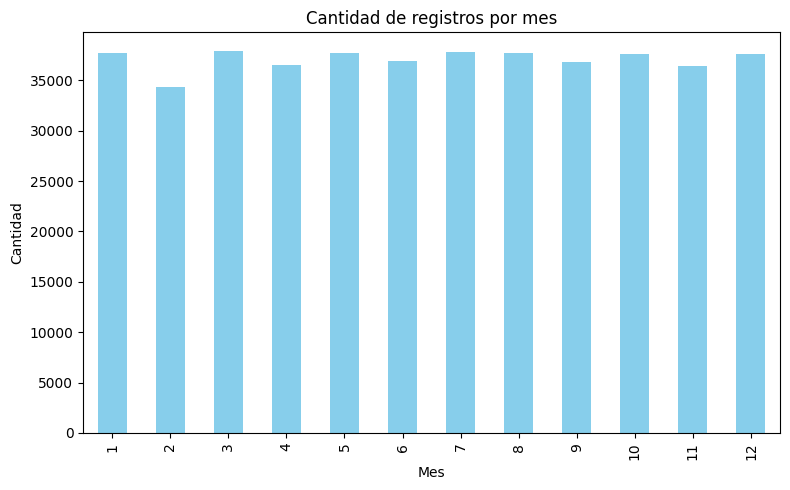

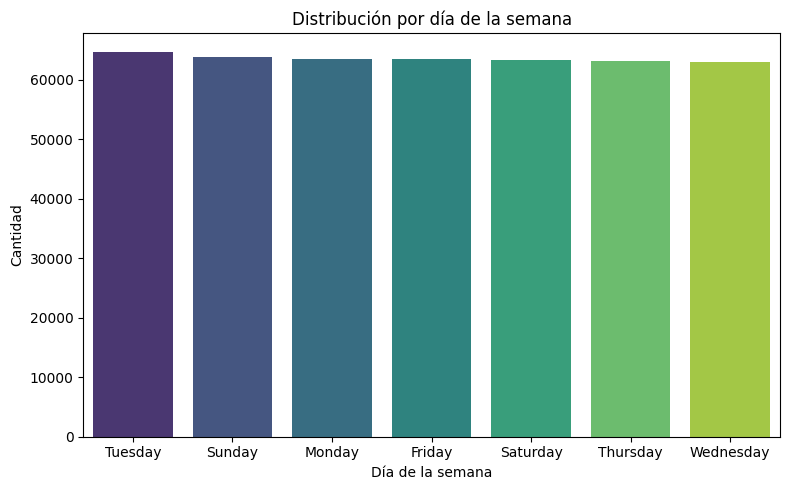

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd

# importamos los datos desde el esquema de silver

df_silver = spark.read.table(full_nombre_silver)

# Convertimos el DataFrame Spark a Pandas para visualización
df_pd = df_silver.select("month", "dayofweek", "nameofday").toPandas()

# 1. Gráfico de barras: cantidad de registros por mes (matplotlib)
plt.figure(figsize=(8,5))
df_pd['month'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Cantidad de registros por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()

# 2. Distribución por día de la semana (seaborn countplot)
plt.figure(figsize=(8,5))
sns.countplot(data=df_pd, x='nameofday', order=df_pd['nameofday'].value_counts().index, palette='viridis')
plt.title('Distribución por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()

# 3. Gráfico interactivo: cantidad de registros por día de la semana (plotly)
df_counts = df_pd['nameofday'].value_counts().reset_index()
df_counts.columns = ['nameofday', 'count']

fig = px.bar(
    df_counts,
    x='nameofday',
    y='count',
    labels={'nameofday': 'Día de la semana', 'count': 'Cantidad'},
    title='Cantidad de registros por día de la semana (interactivo)'
)
fig.show()

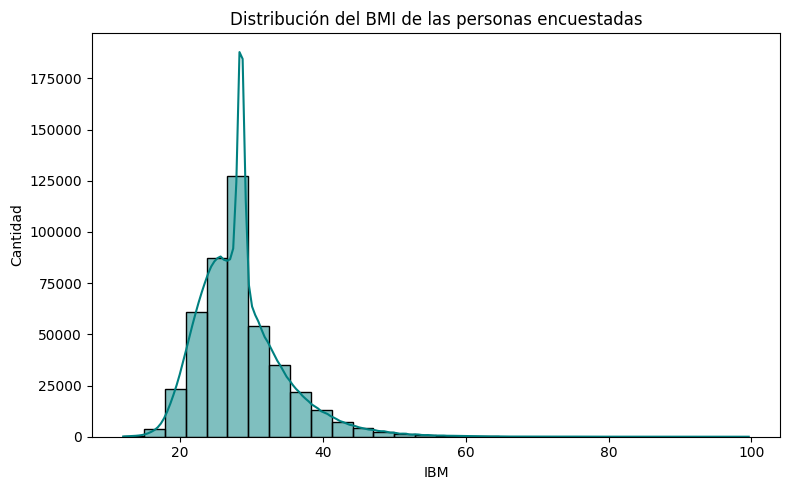

In [0]:
# Suponiendo que la columna 'BMI' representa el índice de masa corporal de las personas encuestadas
# Si la columna se llama diferente (por ejemplo, 'BMI'), reemplaza 'IBM' por el nombre correcto

df_ibm_pd = df_silver.select("BMI").toPandas()

plt.figure(figsize=(8,5))
sns.histplot(df_ibm_pd['BMI'], bins=30, kde=True, color='teal')
plt.title('Distribución del BMI de las personas encuestadas')
plt.xlabel('IBM')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()